## Introduction

This tutorial is a step by step guide to model various interactions between multiple biomolecular models. Broadly, there are three major kinds of interaction and interconnections between different models that this toolbox helps in modeling. The toolbox works with models written in Systems Biology Markup Language (SBML), effectively taking multiple SBML models as input models and giving a new model written in SBML which models the interaction as desired by the user between the input models. 

### Interaction Modeling 
There are different kinds of interactions that commonly occur which can be modeled using this toolbox:-

1. **Shared resources** -  A user defined list of species for a System which all the Subsystems that are placed inside the System share among them as common resources. So, the multiple Subsystems with SBML models in a System will share these species, rather than having different species for each (as would be the case if they were isolated or in different Systems). 


2. **Combine subsystems** - A list of Subsystems may be combined together as desired by the user. A combination of multiple Subsystems gives a new Subsystem with all components of the different input Subsystems merged together. Also, if desired, all species with the same name that occur across different subsystems may be combined in the combined model. When calling the member function, the argument for `combineNames` is set as `True` if it is desired to combine all species which have the same `name` attribute. A `False` for the argument would keep all the Species separate even if they have the same name (however, if they are in the same System, the shared species (as described above in 1) will still be combined). In this case, all components of the Subsystems will be merged together.


3. Other interactions - 
   
   a. **Species Identification** - To model interactions where Species A in Subsystem A activates Species B in Subsystem B. Species B is not active in another Subsystem but when these two species are identified and the user specifies that the Species A in Subsystem A will activate Species B in Subsystem B, it is activated and carries on its set of reactions in Subsystem B. Without this interaction modeling, Species B might not be produced at all, and would not carry out the subsequent reactions in Subsystem B. When the interaction is modeled, the Species B bound to Species A goes into all the reactions as one, and the initial amount of the new combined Species is the sum of the amounts of Species A and Species B. This new combined species will be produced by the reactions in Subsystem A and hence would lead to the reactions in Subsystem B to be carried out.
    When in isolation, Subsystem B, may activate Species B using a different Species, for example, an input species which gets into some reactions which produce Species B, hence activating it and causing subsequent reactions. When modeling the interaction described above, we would want to make the input species in Subsystem B to be obsolete, since, it is desired that Species A in Subsystem A should activate Species B. To achieve this, the name of the input species may be given when calling the member function for this interconnection. This argument is an optional argument in this method and is set to `None` by default.  
    
    b. **Sequestration**  - To model interactions where Species A and Species B bind together to form a complex A:B and hence get sequestered. $$A + B <-> A:B$$ The binding rates are mandatory arguments for this function call (the user needs to specify the identifiers of the new parameters that would be added to get the kinetic law and the user also provides the mathematical formula for the reaction rate and if the reaction is reversible or not). A new reaction is added to the model as shown above. 
    
### Example

To demonstrate al of the functionalities described above, we consider three models written in SBML given to us. Refer to `tutorial_modeling.ipynb` for a tutorial on creating new SBML models from scratch using simple commands. 

For this tutorial, we have two double phosphorylation subsystems and an incoherent feedforward loop subsystem given as SBML files. We intend to have all of the three subsystems inside a synthetic cell and use them as examples to demonstrate the different interconnections and interaction modeling.

Import the required libraries from the modules class. 

In [1]:
from libsbml import *
from modules.System import *
from modules.Subsystem import *
from modules.SimpleModel import *
from modules.NewReaction import *

Create a system. Example - A cell system which acts as a container for 
all of the different subsystems. Here, cell is an object of the System class. 

Specify the list of resources which are shared for this System. Usage - `self.ListOfSharedResources = ['X','Y']`. The ListOfSharedResources is maintained for objects of System class.

The three Subsystems are created inside the System using `self.createSubsystem(filename, component_suffix = '')` of the System class, which takes a SBML file as its first argument and an optional string argument which is used to suffix all elements of the Subsystem. For example, in the DP1 call, the string 'DP1' will be suffixed to identifiers of all Species, Reactions, Parameters etc. 

The System class call of `self.ListOfSubsystem` prints the Subsystem objects in the System.

In [2]:
cell = System('cell')
cell.ListOfSharedResources = ['inP','X:P']
DP1 = cell.createSubsystem('models/DP.xml','DP1')
DP2 = cell.createSubsystem('models/DP.xml','DP2')
IFFL = cell.createSubsystem('models/IFFL.xml','IFFL')
print(cell.ListOfSubsystems)

[<modules.Subsystem.Subsystem object at 0x000001FF70FD7E48>, <modules.Subsystem.Subsystem object at 0x000001FF03C1DEB8>, <modules.Subsystem.Subsystem object at 0x000001FF03C1DEF0>]


### Shared Cellular Resources
Set the list of shared resources to the cell using its member function `self.setSharedResources()`. Modeling of bullet point number 1 is done using this member function. 
Usage - `self.setSharedResources()`, sets the `self.ListOfSharedResources` to the Subsystems that are currently present inside the System and returns a new Subsystem with the combined model of all the Subsystems together sharing resources.
Using `writeSBML`, this shared Subsystem model is written to an SBML file. On running the following code, the file should be generated in the models folder within the current directory. The shared Subsystem model can be simulated using bioscrape. The result is plotted on running the following. You may change the species you wish to plot in the `plotSbmlWithBioscrape(...)` command below by changing the `ListOfSpeciesToPlot` argument.

WARNING -- Multiple species with name X:P:P found. Returning a list
WARNING -- There are multiple species with the name X:P:P in plot function. Suffixed species will be plotted 


C:\Users\apand\synBio\txtlsim-python\BioSIMI-Python\modules\utilityFunctions.py:61: UserWarning: Warning: SBML model contains reversible reaction!
Please check rate expressions and ensure they are non-negative before doing stochastic simulations. This warning will always appear if you are using SBML 1 or 2
  m = bioscrape.types.read_model_from_sbml(filename)


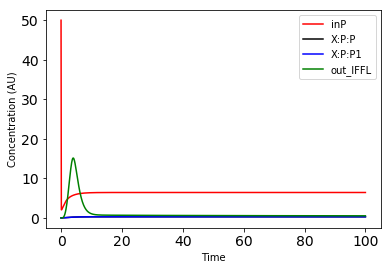

In [5]:
shared_subsystem = cell.setSharedResources()
writeSBML(shared_subsystem.getSubsystemDoc(),'models/DP_IFFL_shared.xml')
timepoints = np.linspace(0,100,1000)

# Usage - plotSbmlWithBioscrape(filename, initialTime, timepoints, 
# ListOfSpeciesToPlot, xLabel = 'Time', yLabel = 'Concentration (AU)', xAxisSize = 14, yAxisSize = 14)

plotSbmlWithBioscrape('models/DP_IFFL_shared.xml',0,timepoints,['inP','X:P:P','out_IFFL'])

### Combining multiple SBML models 
The following code snippet implements the second bullet point in the interconnections modeling described above. The `combineSubsystems` method of the Subsystem class is used.
Usage - `self.combineSubsystems(ListOfSubsystems, combineAllWithSameNames)`

The Subsystem object which calls the `combineSubsystems` method is a new subsystem object which would contain the combined model.

The second argument is Boolean which is True if all species with same names need to be merged and False otherwise. 

BioSIMI-Python WARNING -- Removing all duplicates of the reaction inP + X <-> inP:X in the combined model. Check the reaction rate to ensure model is consistent.
BioSIMI-Python WARNING -- Removing all duplicates of the reaction inP:X --> inP + X:P in the combined model. Check the reaction rate to ensure model is consistent.
BioSIMI-Python WARNING -- Removing all duplicates of the reaction E + X:P <-> E:X:P in the combined model. Check the reaction rate to ensure model is consistent.
BioSIMI-Python WARNING -- Removing all duplicates of the reaction E:X:P --> E + X in the combined model. Check the reaction rate to ensure model is consistent.
BioSIMI-Python WARNING -- Removing all duplicates of the reaction inP + X:P <-> inP:X:P in the combined model. Check the reaction rate to ensure model is consistent.
BioSIMI-Python WARNING -- Removing all duplicates of the reaction inP:X:P --> X:P:P + inP in the combined model. Check the reaction rate to ensure model is consistent.
BioSIMI-Python WAR

C:\Users\apand\synBio\txtlsim-python\BioSIMI-Python\modules\utilityFunctions.py:61: UserWarning: Warning: SBML model contains reversible reaction!
Please check rate expressions and ensure they are non-negative before doing stochastic simulations. This warning will always appear if you are using SBML 1 or 2
  m = bioscrape.types.read_model_from_sbml(filename)
C:\Users\apand\synBio\txtlsim-python\BioSIMI-Python\modules\utilityFunctions.py:61: UserWarning: Warning! Useless parameter k1f_DP2
  m = bioscrape.types.read_model_from_sbml(filename)
C:\Users\apand\synBio\txtlsim-python\BioSIMI-Python\modules\utilityFunctions.py:61: UserWarning: Warning! Useless parameter k1r_DP2
  m = bioscrape.types.read_model_from_sbml(filename)
C:\Users\apand\synBio\txtlsim-python\BioSIMI-Python\modules\utilityFunctions.py:61: UserWarning: Warning! Useless parameter k2f_DP2
  m = bioscrape.types.read_model_from_sbml(filename)
C:\Users\apand\synBio\txtlsim-python\BioSIMI-Python\modules\utilityFunctions.py:61: 

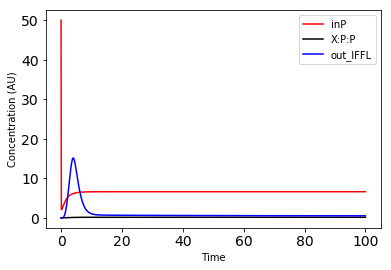

In [6]:
combined_subsystem = cell.createNewSubsystem(3,1)
combined_subsystem.combineSubsystems([DP1, DP2, IFFL], True)
writeSBML(combined_subsystem.getSubsystemDoc(),'models/DP_IFFL_combined.xml')
plotSbmlWithBioscrape('models/DP_IFFL_combined.xml',0,timepoints,['inP','X:P:P','out_IFFL'])

### Species Identification Interaction Modeling
For the interaction described in (3a) above, the user gives a map of the interaction modeling that is desired. This map uses species names. User specifies how the systems interact by defining the following map
Usage - `interactionMap[speciesA] = speciesB` is a dictionary specifying the map, there may be multiple such entries. (Note that Species A and Species B are as described above in the example.  

To model this in a new Subsystem and get a SBML file for it, call the connectInteraction member function of the Subsystem class with the new connected subsystem object which should contain the connected Subsystem model.
Usage - `self.connectSubsystems(ListOfSubsystems, combineAllWithSameNames, interactionMap, inputSpecies)`

The resulting Subsystem model in SBML format is stored in the given filename and is simulated using bioscrape. 

BioSIMI-Python WARNING -- Removing all duplicates of the reaction inP + X <-> inP:X in the combined model. Check the reaction rate to ensure model is consistent.
BioSIMI-Python WARNING -- Removing all duplicates of the reaction inP:X --> inP + X:P in the combined model. Check the reaction rate to ensure model is consistent.
BioSIMI-Python WARNING -- Removing all duplicates of the reaction E + X:P <-> E:X:P in the combined model. Check the reaction rate to ensure model is consistent.
BioSIMI-Python WARNING -- Removing all duplicates of the reaction E:X:P --> E + X in the combined model. Check the reaction rate to ensure model is consistent.
BioSIMI-Python WARNING -- Removing all duplicates of the reaction inP + X:P <-> inP:X:P in the combined model. Check the reaction rate to ensure model is consistent.
BioSIMI-Python WARNING -- Removing all duplicates of the reaction inP:X:P --> X:P:P + inP in the combined model. Check the reaction rate to ensure model is consistent.
BioSIMI-Python WAR

C:\Users\apand\synBio\txtlsim-python\BioSIMI-Python\modules\utilityFunctions.py:61: UserWarning: Warning: SBML model contains reversible reaction!
Please check rate expressions and ensure they are non-negative before doing stochastic simulations. This warning will always appear if you are using SBML 1 or 2
  m = bioscrape.types.read_model_from_sbml(filename)
C:\Users\apand\synBio\txtlsim-python\BioSIMI-Python\modules\utilityFunctions.py:61: UserWarning: Warning! Useless parameter k1f_DP2
  m = bioscrape.types.read_model_from_sbml(filename)
C:\Users\apand\synBio\txtlsim-python\BioSIMI-Python\modules\utilityFunctions.py:61: UserWarning: Warning! Useless parameter k1r_DP2
  m = bioscrape.types.read_model_from_sbml(filename)
C:\Users\apand\synBio\txtlsim-python\BioSIMI-Python\modules\utilityFunctions.py:61: UserWarning: Warning! Useless parameter k2f_DP2
  m = bioscrape.types.read_model_from_sbml(filename)
C:\Users\apand\synBio\txtlsim-python\BioSIMI-Python\modules\utilityFunctions.py:61: 

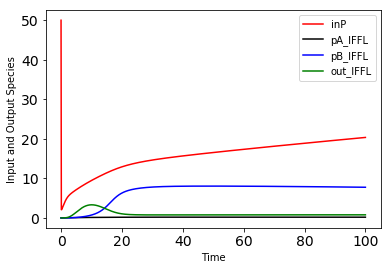

In [7]:
interactionMap = {}
interactionMap['X:P:P'] = 'pA_IFFL'
# (Optional) The following species was used in IFFL model for when its isolated.
# But, now DP output activates the protein expressions so the input to IFFL should be invalid. 
inputSpecies = 'inp_IFFL' #The species which is invalid in the connected model


connected_subsystem = cell.createNewSubsystem(3,1)
connected_subsystem.connectSubsystems([DP1, DP2, IFFL], True, interactionMap, inputSpecies)


# (Optional) Write the connected document to SBML file
writeSBML(connected_subsystem.getSubsystemDoc(),'models/DP_IFFL_connected.xml')

plotSbmlWithBioscrape('models/DP_IFFL_connected.xml',0,
timepoints,['inP','pA_IFFL','pB_IFFL','out_IFFL'],'Time',
'Input and Output Species',14,14)

### Other available utility functions
There are other optional steps that you may try or find the need for -

(Optional) Give a new string to suffix all components of the model. 
By default, the names are suffixed by the keyword given to make the Subsystem object.
Usage -  `self.suffixAllElementIds(string)`
Example - `DP1_doc = DP1.suffixAllElementIds('DPx')`


(Optional) Rename IDs of any species/compartments or any other component of the 
subsystem as desired. This may be a helpful utility function to make sure 
that the shared resources (and other interacting elements) have same IDs or names (as desired)
To rename ID of a component and to propagate the changes everywhere in the model, use the following method of the Subsystem class.
Usage - `self.renameSId(old_id, new_id)` (where the ids are string type)
Example - `DP1.renameSId('inp_DP1','inp_DP1_new')`

(Optional) To rename the names of any species, use the following method of the Subsystem class
Usage - `self.renameSName(old_name, new_name)`
Example - `DP1.renameSName('inp', 'input')`
renames all 'inp' named species to 'input'

(Optional) To give a compartment to put the subsystem in, use the following method of the Subsystem class
By default, the subsystem is kept in the "cell" compartment (the System object used)
Usage - `self.setSubsystemCompartments(newCompartments)`
Example -
```
newCompartment = ['cell_new']
DP1.setSubsystemCompartments(newCompartment)
```
(Optional) Write the Subsystem model created to output an SBML file
```
DP1_doc = DP1.getSubsystemDoc()
writeSBML(DP1_doc,'models/DP1.xml')
```
